In [2]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import * 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from imutils import paths
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt    
debug = 0

21892


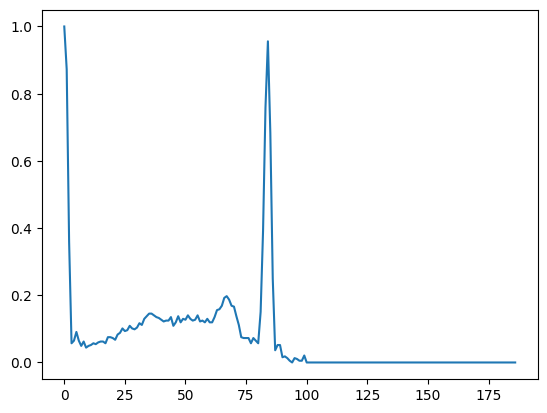

In [5]:
train_df=pd.read_csv('Dataset/mitbih_train.csv',header=None)
test_df=pd.read_csv('Dataset/mitbih_test.csv',header=None)

target_train=train_df.iloc[:,-1]
target_test=test_df.iloc[:,-1]

y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

X_train=train_df.iloc[:,:-1].values
X_test=test_df.iloc[:,:-1].values

X_train_noise=np.array(X_train)
X_test_noise=np.array(X_test)
plt.plot(X_train[16])
print(len(y_test))

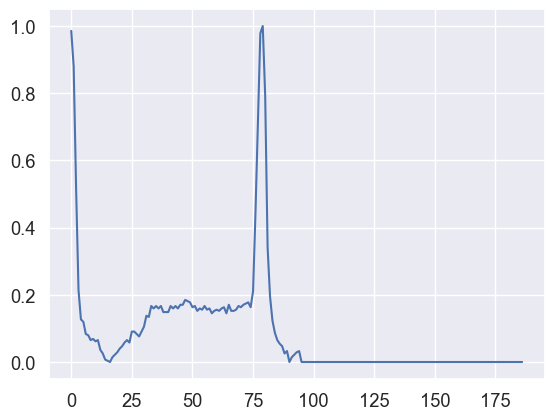

ValueError: could not broadcast input array from shape (187,187) into shape (187,1)

In [228]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.01,187)
    out=signal+noise
    return out

print(X_train.shape)
X_train_noise=np.array(X_train)
X_test_noise=np.array(X_test)
plt.plot(X_train[10])
plt.show()
for i in range(len(X_train_noise)):
    X_train_noise[i,:187]= add_gaussian_noise(X_train_noise[i,:187])
for i in range(len(X_test_noise)):
    X_test_noise[i,:187]= add_gaussian_noise(X_test_noise[i,:187])
    
X_train_noise= X_train_noise.reshape(len(X_train_noise), X_train_noise.shape[1],1)
X_train= X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_test_noise= X_test_noise.reshape(len(X_test_noise), X_test_noise.shape[1],1)


X_train=np.float32(X_train)
X_train_noise=np.float32(X_train_noise)
X_test=np.float32(X_test)
X_test_noise=np.float32(X_test_noise)

plt.plot(X_train[10])
plt.show()
plt.plot(X_train_noise[10],color='red')
plt.show()
plt.plot(X_train[300])
plt.show()
plt.plot(X_train_noise[300],color='red')
plt.show()
#normalize mean
X_train_noise=(X_train_noise-X_train_noise.mean())/X_train_noise.std()
X_test_noise=(X_test_noise-X_test_noise.mean())/X_test_noise.std()

plt.show()

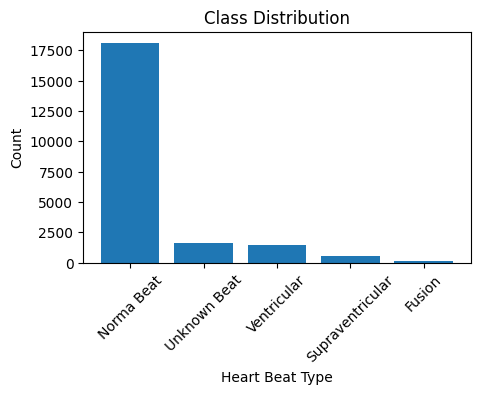

Class Imbalance Ratio: 0.01


In [127]:
import pandas as pd
import matplotlib.pyplot as plt

train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)  

def c_name_labeler(data_portion):
    label_to_name = {0:'Norma Beat',1:'Supraventricular',2:'Ventricular',3:'Fusion',4:'Unknown Beat',}
    class_names=[]
    encoded_labels = []
    for i in range (len(data_portion)):
        encoded_labels.append(data_portion[i])
    for label in encoded_labels:
        class_name = label_to_name[label]
        class_names.append(class_name)
    return class_names

label_name=c_name_labeler(class_distribution.index)

class_labels = target_test
class_distribution = class_labels.value_counts() 
# Plot the class distribution
plt.figure(figsize=(5,3))
plt.bar(label_name, class_distribution.values)
plt.xlabel('Heart Beat Type')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Calculate and print the class imbalance ratio
imbalance_ratio = class_distribution.min() / class_distribution.max()
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")



In [139]:
from imblearn.over_sampling import SMOTE
from collections import Counter 
smote = SMOTE(sampling_strategy='auto')  
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)  

In [140]:
def class_name_labeler(data_portion):
    label_to_name = {0:'N',1:'S',2:'V',3:'F',4:'Q',}
    class_names=[]
    encoded_labels = []
    for i in range (len(data_portion)):
        encoded_labels.append(data_portion[i])
    for label in encoded_labels:
        class_name = label_to_name[label]
        class_names.append(class_name)
    return class_names

In [173]:

def create_clients(data_list, label_list, num_clients=8, initial='clients'):
     #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    #randomize the data
    data = list(zip(data_list, label_list))
    random.shuffle(data)  
    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
    assert(len(shards) == len(client_names))
    
    return {client_names[i] : shards[i] for i in range(len(client_names))} 


def batch_data(data_shard, bs=32):
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)
    return local_count/global_count


def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad

    def test_model(X_test, Y_test,  model, comm_round):
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        #logits = model.predict(X_test, batch_size=100)
        y_predicted = model.predict(X_test)
        loss = cce(Y_test, y_predicted)
        acc = accuracy_score(tf.argmax(y_predicted, axis=1), tf.argmax(Y_test, axis=1))
        print('Comm_round: {} | Global_acc: {:.3%} | Global_loss: {}'.format(comm_round, acc, loss))
        return acc, loss


In [174]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [179]:
len(X_train), len(X_test), len(y_train), len(y_test) 
clients = create_clients(X_resampled, y_resampled, num_clients=10, initial='client')
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

lr = 0.01
comms_round = 300
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr,
                                           decay=lr / comms_round,
                                           momentum=0.9
                                           )       

In [180]:
#initialize global model 
feature_size=187
smlp_global = SimpleMLP()
global_model = smlp_global.build(feature_size, 5)  
global_acc_list = []
global_loss_list = []
#Global training loop
for comm_round in range(comms_round): 
    global_weights = global_model.get_weights() 
    scaled_local_weight_list = list()
    all_client_names = list(clients_batched.keys())#randomize client data - using keys
    client_names = random.sample(all_client_names, k=10)
    #print(client_names, len(client_names))
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(feature_size, 5)
        local_model.compile(loss=loss, 
                            optimizer=optimizer, 
                            metrics=metrics)
        
        local_model.set_weights(global_weights) #set local model weight to the weight of the global model
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights) #update global model 

    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

685/685 [==============================] - 2s 2ms/step
Comm_round: 0 | Global_acc: 71.419% | Global_loss: 1.2638496160507202
685/685 [==============================] - 2s 3ms/step
Comm_round: 1 | Global_acc: 82.884% | Global_loss: 1.1552088260650635
685/685 [==============================] - 2s 2ms/step
Comm_round: 2 | Global_acc: 85.999% | Global_loss: 1.109423041343689
685/685 [==============================] - 2s 3ms/step
Comm_round: 3 | Global_acc: 87.758% | Global_loss: 1.081925392150879
685/685 [==============================] - 2s 3ms/step
Comm_round: 4 | Global_acc: 87.763% | Global_loss: 1.0808345079421997
685/685 [==============================] - 2s 2ms/step
Comm_round: 5 | Global_acc: 87.913% | Global_loss: 1.0719891786575317
685/685 [==============================] - 2s 2ms/step
Comm_round: 6 | Global_acc: 90.485% | Global_loss: 1.0444689989089966
685/685 [==============================] - 1s 2ms/step
Comm_round: 7 | Global_acc: 92.468% | Global_loss: 1.022674322128296
685

IID | total comm rounds 300


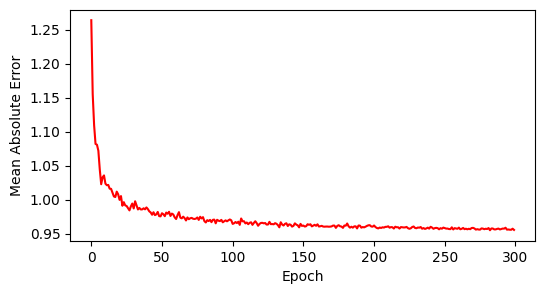

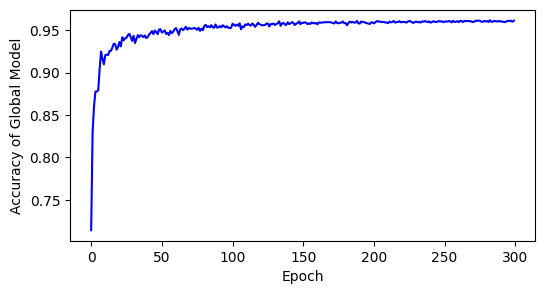

In [196]:
# IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.ylabel("Mean Absolute Error")
plt.xlabel("Epoch") 
plt.plot(list(range(0,len(global_loss_list))), global_loss_list,color='red')

plt.figure(figsize=(6,3))  
plt.plot(list(range(0,len(global_acc_list))), global_acc_list,color='blue')
plt.ylabel("Accuracy of Global Model")
plt.xlabel("Epoch") 
print('IID | total comm rounds', len(global_acc_list))

In [199]:
print(max(global_acc_list))
print(min(global_loss_list))

0.9617211766855472
tf.Tensor(0.95505476, shape=(), dtype=float32)


In [ ]:
iid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
iid_df.to_csv('MNIST_IID.csv',index=False)

In [218]:
print(len(X_test))
y_pred=global_model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)

30


ValueError: in user code:

    File "c:\Users\Sileshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Sileshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Sileshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Sileshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\Sileshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Sileshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 187), found shape=(None, 4)


In [215]:

cm = confusion_matrix(target_test, y_pred)
    
# Define the target class names
target_names = list("NSVFQ") 
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix') 

clf_report = classification_report(target_test, y_pred, target_names=target_names, output_dict=True)
print(classification_report(target_test, y_pred, target_names=target_names))
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [21892, 30]

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
cm = confusion_matrix(target_test, y_preds) 
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100 
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)') 
plt.show() 

ValueError: Found input variables with inconsistent numbers of samples: [21892, 30]

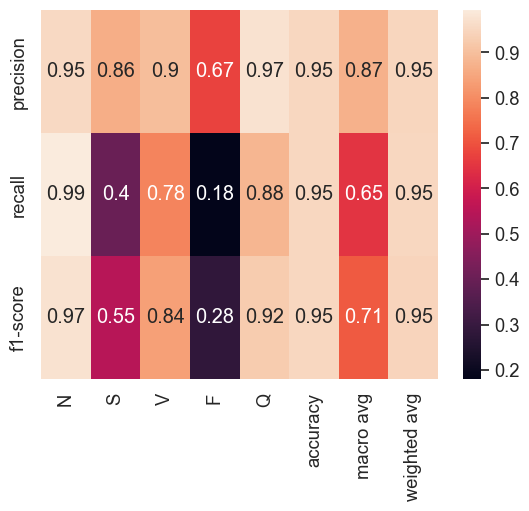

In [209]:
from sklearn.metrics import classification_report
import seaborn as sns
target_names = list("NSVFQ") 
clf_report = classification_report(target_test, y_pred, target_names=target_names,output_dict=True) 
plt.show(sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True))

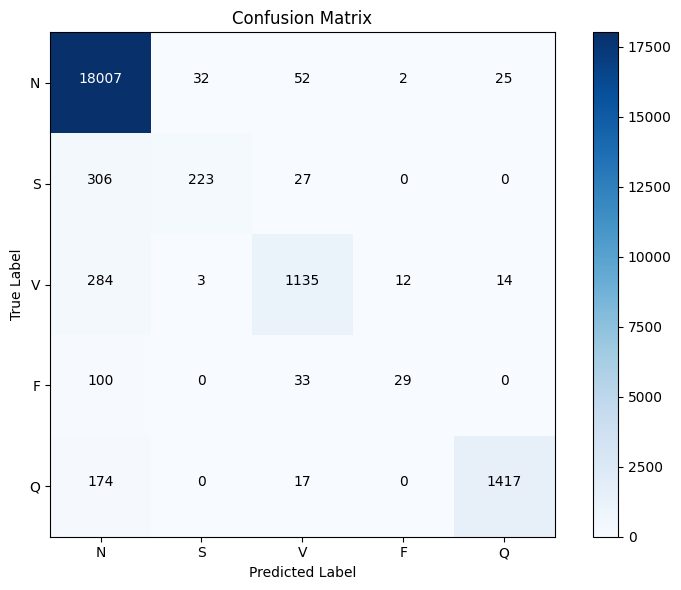

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=0)
    plt.yticks(tick_marks, labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
cm = confusion_matrix(target_test, y_pred) 
plot_confusion_matrix(cm, target_names)


### Non-IID

In [ ]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    # data = list(zip(image_list, label_list))
    # random.shuffle(data)  # <- IID
    
    # sort data for non-iid
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
lr = 0.01 
comms_round = 300
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [ ]:
#initialize global model

build_shape = 784 #(32, 32, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    random.shuffle(client_names)
    if debug: 
        # print('all_client_names', all_client_names)
        print('client_names', client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

In [ ]:
# Non-IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Non-IID | total comm rounds', len(global_acc_list))           

In [ ]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
noniid_df.to_csv('CIFAR-10_Non-IID.csv',index=False)